In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import altair as alt

from path_explain.path_explainer_tf import PathExplainerTF
from path_explain import utils
from plot.scatter import scatter_plot
from plot.summary import summary_plot

In [4]:
utils.set_up_environment(visible_devices='0')

In [5]:
n = 5000
d = 5
noise = 0.5
X = np.random.randn(n, d)
y = np.sum(X, axis=-1) + 2 * np.prod(X[:, 0:2], axis=-1)

In [6]:
threshold = int(n * 0.8)
X_train = X[:threshold]
y_train = y[:threshold]
X_test  = X[threshold:]
y_test  = y[threshold:]

In [7]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(d,)))
model.add(tf.keras.layers.Dense(units=10,
                                use_bias=True,
                                activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=5,
                                use_bias=True,
                                activation=tf.keras.activations.softplus))
model.add(tf.keras.layers.Dense(units=1,
                                use_bias=False,
                                activation=None))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


In [9]:
learning_rate = 0.1
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate),
              loss=tf.keras.losses.MeanSquaredError())

In [10]:
model.fit(X_train, y_train, batch_size=50, epochs=20, verbose=2, validation_split=0.8)

Train on 799 samples, validate on 3201 samples
Epoch 1/20
799/799 - 1s - loss: 6.5909 - val_loss: 3.6020
Epoch 2/20
799/799 - 0s - loss: 3.2548 - val_loss: 3.0772
Epoch 3/20
799/799 - 0s - loss: 2.9300 - val_loss: 2.7568
Epoch 4/20
799/799 - 0s - loss: 2.4870 - val_loss: 2.3896
Epoch 5/20
799/799 - 0s - loss: 2.2778 - val_loss: 1.6789
Epoch 6/20
799/799 - 0s - loss: 2.4520 - val_loss: 1.1024
Epoch 7/20
799/799 - 0s - loss: 0.7971 - val_loss: 0.6408
Epoch 8/20
799/799 - 0s - loss: 0.9972 - val_loss: 0.6210
Epoch 9/20
799/799 - 0s - loss: 0.5793 - val_loss: 0.7983
Epoch 10/20
799/799 - 0s - loss: 0.7818 - val_loss: 1.3803
Epoch 11/20
799/799 - 0s - loss: 0.7947 - val_loss: 0.4360
Epoch 12/20
799/799 - 0s - loss: 0.4316 - val_loss: 0.2711
Epoch 13/20
799/799 - 0s - loss: 0.2965 - val_loss: 0.5779
Epoch 14/20
799/799 - 0s - loss: 0.2550 - val_loss: 0.2121
Epoch 15/20
799/799 - 0s - loss: 0.2050 - val_loss: 0.2158
Epoch 16/20
799/799 - 0s - loss: 0.1452 - val_loss: 0.3241
Epoch 17/20
799/79

In [11]:
model.evaluate(X_test, y_test, batch_size=50, verbose=2)

1000/1 - 0s - loss: 0.1822


0.21806954890489577

In [12]:
y_test_pred = model.predict(X_test, batch_size=50)

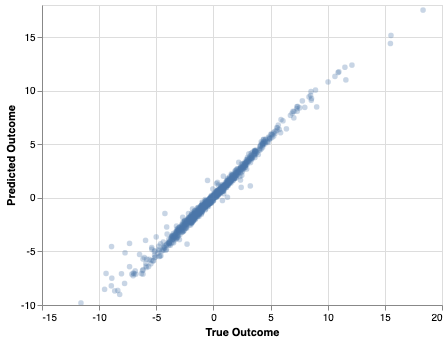

In [13]:
df = pd.DataFrame({
    'Predicted Outcome': y_test_pred[:, 0],
    'True Outcome': y_test
})
alt.Chart(df).mark_point(filled=True, opacity=0.3).encode(
    alt.X('True Outcome:Q'),
    alt.Y('Predicted Outcome:Q')
)

In [14]:
explainer = PathExplainerTF(model)

In [15]:
feature_values = X_test

## Using Expected Gradients

In [16]:
attributions = explainer.attributions(feature_values, X_train,
                     batch_size=100, num_samples=100,
                     use_expectation=True, output_indices=[0] * len(feature_values),
                     verbose=True)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 1000/1000 [00:03<00:00, 310.37it/s]


In [17]:
interactions = explainer.interactions(feature_values, X_train,
                         batch_size=100, num_samples=100,
                         use_expectation=True, output_indices=[0] * len(feature_values),
                         verbose=True, interaction_index=None)

100%|██████████| 1000/1000 [02:53<00:00,  5.75it/s]


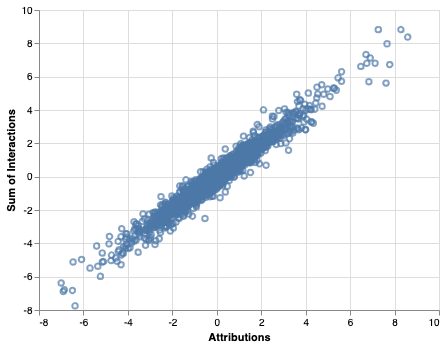

In [18]:
data_df = pd.DataFrame({
    'Attributions': attributions.flatten(),
    'Sum of Interactions': np.sum(interactions, axis=-1).flatten()
})
alt.Chart(data_df).mark_point().encode(
    alt.X('Attributions:Q'),
    alt.Y('Sum of Interactions')
)

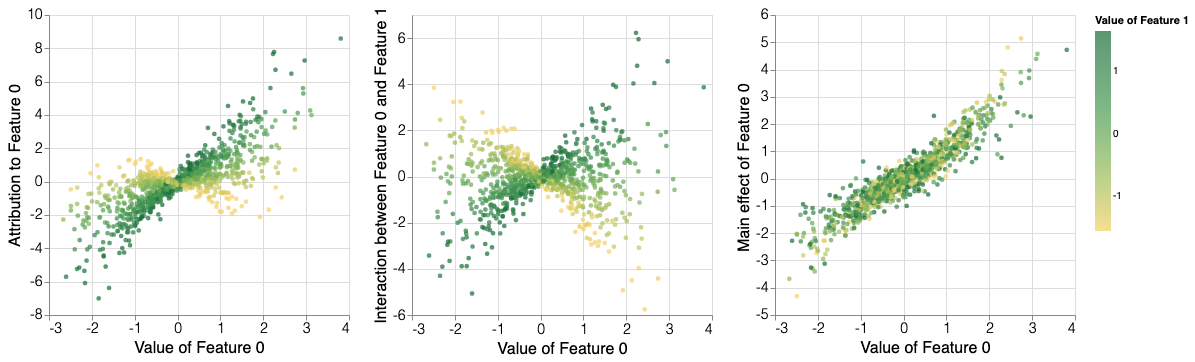

In [19]:
scatter_plot(attributions,
             feature_values,
             feature_index=0,
             interactions=interactions,
             color_by=1,
             feature_names=None)

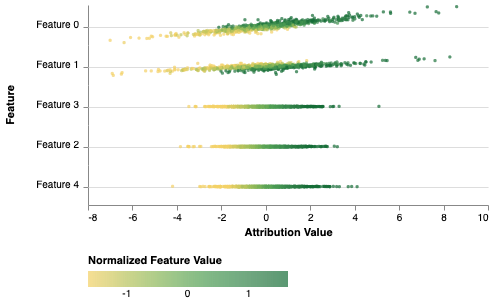

In [20]:
summary_plot(attributions,
             feature_values,
             interactions=interactions,
             interaction_feature=0,
             feature_names=None,
             plot_top_k=None)

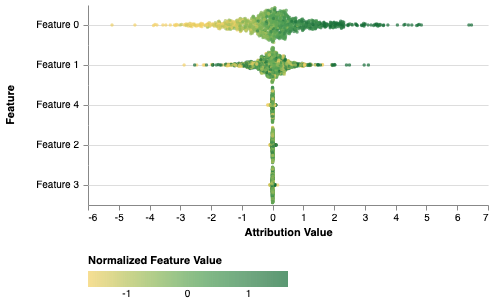

In [21]:
summary_plot(interactions[:, 0],
             feature_values,
             interactions=None,
             interaction_feature=None,
             feature_names=None,
             plot_top_k=None)

## Using Integrated Gradients

In [22]:
attributions = explainer.attributions(feature_values, np.zeros((1, 5)),
                     batch_size=100, num_samples=100,
                     use_expectation=False, output_indices=[0] * len(feature_values),
                     verbose=True)

100%|██████████| 1000/1000 [00:03<00:00, 331.68it/s]


In [23]:
interactions = explainer.interactions(feature_values, np.zeros((1, 5)),
                         batch_size=100, num_samples=100,
                         use_expectation=False, output_indices=[0] * len(feature_values),
                         verbose=True, interaction_index=None)

100%|██████████| 1000/1000 [02:49<00:00,  5.90it/s]


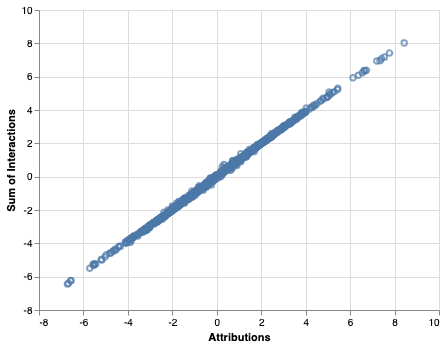

In [24]:
data_df = pd.DataFrame({
    'Attributions': attributions.flatten(),
    'Sum of Interactions': np.sum(interactions, axis=-1).flatten()
})
alt.Chart(data_df).mark_point().encode(
    alt.X('Attributions:Q'),
    alt.Y('Sum of Interactions')
)

In [25]:
k = 1
for i in range(5):
    print('Attribution to feature {}: {:.4f}'.format(i, attributions[k, i]))
    print('Interaction to feature {}: {}'.format(i, ', '.join(['{:.4f}'.format(inter) for inter in interactions[k, i]])))
    print('-----------------------------')

Attribution to feature 0: 0.1314
Interaction to feature 0: 0.0907, 0.0415, 0.0008, -0.0006, -0.0016
-----------------------------
Attribution to feature 1: 1.1951
Interaction to feature 1: 0.0415, 1.1621, 0.0210, -0.0056, -0.0239
-----------------------------
Attribution to feature 2: 0.5452
Interaction to feature 2: 0.0008, 0.0210, 0.5337, -0.0028, -0.0050
-----------------------------
Attribution to feature 3: -0.2908
Interaction to feature 3: -0.0006, -0.0056, -0.0028, -0.2851, 0.0026
-----------------------------
Attribution to feature 4: -0.6164
Interaction to feature 4: -0.0016, -0.0239, -0.0050, 0.0026, -0.5914
-----------------------------


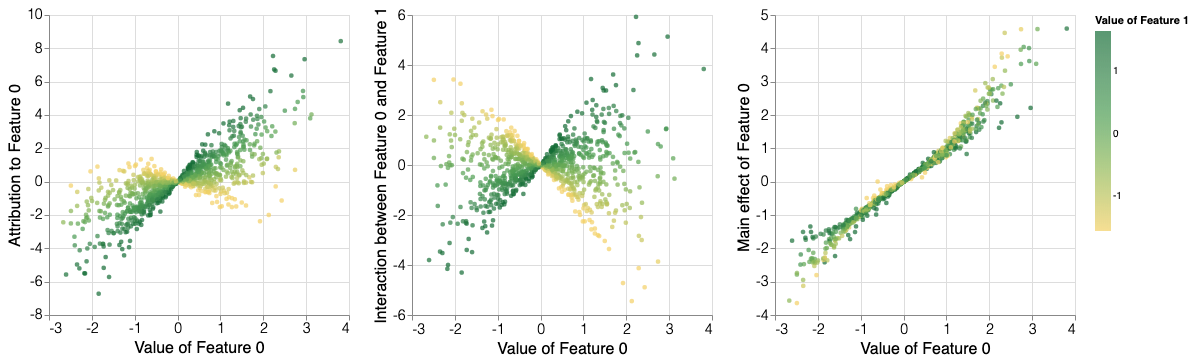

In [26]:
scatter_plot(attributions,
             feature_values,
             feature_index=0,
             interactions=interactions,
             color_by=1,
             feature_names=None)

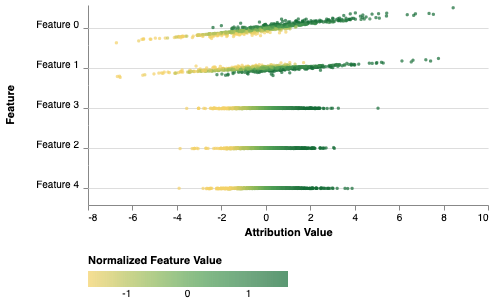

In [27]:
summary_plot(attributions,
             feature_values,
             interactions=interactions,
             interaction_feature=0,
             feature_names=None,
             plot_top_k=None)

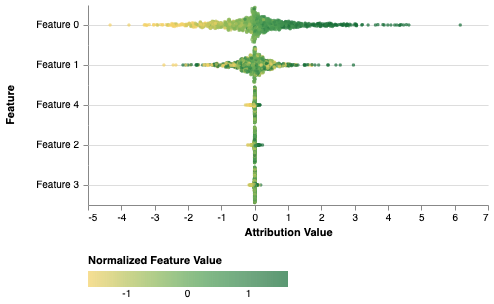

In [28]:
summary_plot(interactions[:, 0],
             feature_values,
             interactions=None,
             interaction_feature=None,
             feature_names=None,
             plot_top_k=None)